
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Subsurface Data Analytics 

### Make a Synthetic Spatial Nonlinear Multivariate Facies-based Dataset

Flexible tool to make a spatial, multivariate dataset for demonstrations and testing new methods

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Import Required Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geostatspy.geostats as geostats    # reimplimentation of GSLIB algorithms in Python
import geostatspy.GSLIB as GSLIB          # GSLIB visualization, subroutines and algorithm wrappers
cmap = plt.cm.inferno                     # color map
import seaborn as sns
from copy import copy                     # deep copies

#### Some Truth Model Parameters

In [7]:
# Truth Model Parameters 
seed = 73075                              # random number seed for repeatable random samples and rejection sampler 
name = 'Por'                              # name of the feature of interest
mean = 0.13                               # univariate distribution mean - assuming Gaussian distribution
stdev = 0.03                              # univariate standard deviation 
nug = 0.1                                 # nugget effect - variogram model
it = 1                                    # type of structure (1 -spherical, 2 - exponential, 3 - Gaussian)
azi = -60.0                                # primary direction/azimuth of continuity (0 = y positive, 90 = x positive)
hmaj = 500                                # variogram range in the major direction
hmin = 200                                # variogram range in the minor direction (major direction + 90)
corr1 = 0.83
corr2 = -0.75

# Make the variogram object
vario = GSLIB.make_variogram(nug,nst=1,it1=it,cc1=1-nug,azi1=azi,hmaj1=hmaj,hmin1=hmin) # make model object

# Make the dummy dataset (should be outside the range of correlation of the model)
df = pd.DataFrame({'X':np.full(100,-9999),'Y':np.full(100,-9999),name:np.random.normal(0.0,1.0,100)})

# Truth Model Grid Parameters
nx = 100; ny = 100                        # number of cells in the x and y directions
xsiz = 10.0; ysiz = 10.0                  # size of the cells in the x and y directions
xmn = xsiz * 0.5; ymn = ysiz * 0.5        # assume origin at 0,0, calculate the 1 cell centroid
xmin = xmn - 0.5*xsiz; ymin = ymn - 0.5*ysiz # assume origin at 0,0, calculate the min and max x/y coordinates
xmax = xmin + nx * xsiz; ymax = ymin + ny * ysiz;
vmin = -3; vmax = 3                   # feature min and max for color bars
sim_ns = np.zeros([6,ny,nx])

Note, I've been really busy, this could have been cleaned up and generalized better. Anyone want to jump in and make this a easy to use tool? It is close and really useful.

#### Declare Functions

I coded up the following functions to sample from the truth model.  These include the following operations:

**regular_sample_MV** 

Function for regular sampling from an exhaustive truth model, a 2D ndarray

* **array** - 2D ndarray with the truth model for feature 1
* **array2** - 2D ndarray with the truth model for feature 2
* **array3** - 2D ndarray with the truth model for feature 3
* **array4** - 2D ndarray with the truth model for feature 4
* **xmin** - minimum x coordinate - truth model extents
* **xmax** - maximum x coordinate
* **ymin** - minimum y coordinate
* **ymax** - maximum y coordinate
* **spacing** - spacing of the samples in x and y
* **minsx** - minimum x coordinate of the samples - sampling window, defaults to extend of the array
* **maxsx** - maximum x coordinate of the samples
* **minsy** - minimum y coordinate of the samples
* **maxsy** - maximum y coordinate of the samples
* **name** - feature 1 name
* **name2** - feature 2 name
* **name3** - feature 3 name
* **name4** - feature 4 name

**random_sample_MV** 

Funciton for random sample from an exhaustive truth model, a 2D ndarray

* **array** - 2D ndarray with the truth model for feature 1
* **array2** - 2D ndarray with the truth model for feature 2
* **array3** - 2D ndarray with the truth model for feature 3
* **array4** - 2D ndarray with the truth model for feature 4
* **xmin** - minimum x coordinate - truth model extents
* **xmax** - maximum x coordinate
* **ymin** - minimum y coordinate
* **ymax** - maximum y coordinate 
* **nsamp** - number of random samples
* **minsx** - minimum x coordinate of the samples - sampling window, defaults to extend of the array
* **maxsx** - maximum x coordinate of the samples
* **minsy** - minimum y coordinate of the samples
* **maxsy** - maximum y coordinate of the samples
* **name** - feature 1 name
* **name2** - feature 2 name
* **name3** - feature 3 name
* **name4** - feature 4 name

**rejection_sample** 

Function to preferentially remove high/low samples from a DataFrame to impose sampling bias

* **df** - DataFrame with the sample data
* **vcol** - feature of interest for the rejection decision, all features are preserved in the output DataFrame
* **frac** - fraction of dataset to remove with the rejection sampler
* **wt_min** - weight for the minimum value - linear interpolation used to assign weights from min to max value 
* **wt_max** - weight for the maximum value

Here's the functions:

In [8]:
def regular_sample_MV(array,array2,array3,array4,xmin,xmax,ymin,ymax,spacing,
                      minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name='Value',name2='Value2',name3='Value3',name4="Value4"):
    x = []; y = []; v = []; v2 = []; v3 = []; v4 = []
    nx = array.shape[1]; ny = array.shape[0]
    xsiz = (xmax-xmin)/nx; ysiz = (ymax-ymin)/ny
    xmn = xmin + 0.5*xsiz; ymn = ymin + 0.5*ysiz
    xx, yy = np.meshgrid(np.arange(xmin, xmax, spacing), np.arange(ymax, ymin, -1 * spacing))
    xx = xx + spacing*0.5; yy = yy - spacing*0.5
    for ix,iy in np.ndindex(xx.shape):
        iix = geostats.getindex(nx,xmn,xsiz,xx[iy,ix])
        iiy = geostats.getindex(ny,ymn,ysiz,yy[iy,ix])
        if yy[iy,ix] >= minsy and yy[iy,ix] <= maxsy: 
            if xx[iy,ix] >= minsx and xx[iy,ix] >= minsx: 
                x.append(xx[iy, ix])
                y.append(yy[iy, ix])
                v.append(array[ny - iiy - 1, iix])
                v2.append(array2[ny - iiy - 1, iix])
                v3.append(array3[ny - iiy - 1, iix])
                v4.append(array4[ny - iiy - 1, iix])
    df = pd.DataFrame(np.c_[x, y, v, v2, v3, v4], columns=["X", "Y", name,name2,name3,name4])
    return df

def random_sample_MV(array,array2,array3,array4,xmin,xmax,ymin,ymax,nsamp=10,minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name='Value',name2='Value2',name3='Value3',name4='Value4'):
    x = []; y = []; v = []; v2 = []; v3 = []; v4 = []
    ny, nx = array.shape   
    xx, yy = np.meshgrid(
        np.arange(xmin, xmax,(xmax-xmin)/float(nx)), np.arange(ymax - 1, ymin - 1, -1 * (ymax-ymin)/float(ny))
    )
    mask = np.zeros([ny,nx])
    for iy in range(0,ny):
        for ix in range(0,nx):
            if xx[iy,ix] >= minsx and xx[iy,ix] <= maxsx:
                if yy[iy,ix] >= minsy and yy[iy,ix] <= maxsy:
                    mask[iy,ix] = 1.0
    
    if nsamp*1.2 > np.sum(mask):
        print('ERROR - too few locations available for number of samples requested!') 
        return pd.DataFrame()
    isamp = 0
    while isamp < nsamp:
        sample_index = np.random.choice(range(nx * ny), 1)
        iy = int(sample_index[0] / ny)
        ix = sample_index[0] - iy * nx
        if mask[iy,ix] == 1:    
            if xx[iy,ix] >= xmin and xx[iy,ix] <= xmax:
                if yy[iy,ix] >= ymin and yy[iy,ix] <= ymax:        
                    x.append(xx[iy, ix])
                    y.append(yy[iy, ix])
                    v.append(array[iy, ix])
                    v2.append(array2[iy, ix])
                    v3.append(array3[iy, ix]) 
                    v4.append(array4[iy, ix])      
                    mask[iy,ix] = 0.0
                    isamp = isamp + 1
    df = pd.DataFrame(np.c_[x, y, v, v2, v3, v4], columns=["X", "Y", name,name2,name3,name4])
    return df

def rejection_sample(df,vcol,frac,wt_min,wt_max):
    value = [np.min(df[vcol].values),np.max(df[vcol].values)]
    wt = [wt_min,wt_max]
    df_copy = df.copy(deep = True)
    df_copy['weights'] = np.interp(df[vcol],value,wt)
    df_sample = df_copy.sample(frac = frac, replace = False, weights = 'weights')
    return df_sample

#### Make Gaussian Spatial Realizations

We will use the common geostatistical method for simulation, known as sequential Gaussian simulation. We will then transform these spatial realizations to:

* realistic univariate distributions

* multivariate correlation

* nonlinear relationships

We will get to a model with:

1. porosity

2. permeability

3. acoustic impedance

4. facies

We will build the porosity, permeability and acoustic impedance models for sand and shale over the area of interest, simulate facies and then merge the continuous features models by-facies into a single model with both facies.

* this is know as the 'cookie-cutter' approach in goemodeling

This simulation method may be conditioned to:

* honor data at data locations 
* honor the global univariate distribution
* honor the variogram

The GeostatsPy method was reimplimented in Python from the original GSLIB code (Pyrcz, M.J.), credit to the authors of GSLIB (Deutsch and Journal, 1998).

We will assume:

* **unconditional / no local data** - the simulation approach actually requires input data, so will will make and input a dummy dataset well outside the model space

* **Gaussian distribution** - the output is standard Gaussian distributed (mean = 0.0 and variance = 1.0) and that will be transformed to a new mean and standard deviation with the affine correction: 

\begin{equation}
z_{new} = \frac{ \sigma_{z_{new}} }{ \sigma_{z_{old}} } (z_{old} - \overline{z}_{old} ) + \overline{z}_{new}
\end{equation}

We build one model for each feature and for each facies


In [9]:
offset = 10

# Calculate the Simulated Truth Model over the Specified Grid and Variogram 
sim_ns[0,:,:] = geostats.sgsim(df,'X','Y',name,wcol=-1,scol=-1,tmin=-9999,tmax=9999,itrans=0,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=-3.0,zmax=3.0,ltail=1,ltpar=-3.0,utail=1,utpar=3.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073+offset,
            ndmin=0,ndmax=100,nodmax=10,mults=0,nmult=2,noct=-1,radius=hmaj,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario)
sim_ns[0,:,:] = GSLIB.affine(sim_ns[0,:,:],0.0,1.0) # correct the mean and variance


sim_ns[1,:,:] = geostats.sgsim(df,'X','Y',name,wcol=-1,scol=-1,tmin=-9999,tmax=9999,itrans=0,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=-3.0,zmax=3.0,ltail=1,ltpar=-3.0,utail=1,utpar=3.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074+offset,
            ndmin=0,ndmax=100,nodmax=10,mults=0,nmult=2,noct=-1,radius=hmaj,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=4,colocorr=corr1,sec_map=sim_ns[0,:,:],vario=vario)
sim_ns[1,:,:] = GSLIB.affine(sim_ns[1,:,:],0.0,1.0) # correct the mean and variance

sim_ns[2,:,:] = geostats.sgsim(df,'X','Y',name,wcol=-1,scol=-1,tmin=-9999,tmax=9999,itrans=0,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=-3.0,zmax=3.0,ltail=1,ltpar=-3.0,utail=1,utpar=3.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73075+offset,
            ndmin=0,ndmax=100,nodmax=10,mults=0,nmult=2,noct=-1,radius=hmaj,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=4,colocorr=corr2,sec_map=sim_ns[0,:,:],vario=vario)
sim_ns[2,:,:] = GSLIB.affine(sim_ns[2,:,:],0.0,1.0) # correct the mean and variance

sim_ns[3,:,:] = geostats.sgsim(df,'X','Y',name,wcol=-1,scol=-1,tmin=-9999,tmax=9999,itrans=0,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=-3.0,zmax=3.0,ltail=1,ltpar=-3.0,utail=1,utpar=3.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73076+offset,
            ndmin=0,ndmax=100,nodmax=10,mults=0,nmult=2,noct=-1,radius=hmaj,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario)
sim_ns[3,:,:] = GSLIB.affine(sim_ns[3,:,:],0.0,1.0) # correct the mean and variance

sim_ns[4,:,:] = geostats.sgsim(df,'X','Y',name,wcol=-1,scol=-1,tmin=-9999,tmax=9999,itrans=0,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=-3.0,zmax=3.0,ltail=1,ltpar=-3.0,utail=1,utpar=3.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73077+offset,
            ndmin=0,ndmax=100,nodmax=10,mults=0,nmult=2,noct=-1,radius=hmaj,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=4,colocorr=corr1,sec_map=sim_ns[3,:,:],vario=vario)
sim_ns[4,:,:] = GSLIB.affine(sim_ns[4,:,:],0.0,1.0) # correct the mean and variance

sim_ns[5,:,:] = geostats.sgsim(df,'X','Y',name,wcol=-1,scol=-1,tmin=-9999,tmax=9999,itrans=0,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=-3.0,zmax=3.0,ltail=1,ltpar=-3.0,utail=1,utpar=3.0,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73078+offset,
            ndmin=0,ndmax=100,nodmax=10,mults=0,nmult=2,noct=-1,radius=hmaj,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=4,colocorr=corr2,sec_map=sim_ns[3,:,:],vario=vario)
sim_ns[5,:,:] = GSLIB.affine(sim_ns[5,:,:],0.0,1.0) # correct the mean and variance



 Data for SGSIM: Number of acceptable data     = 100
                 Number trimmed                = 0
                 Weighted Average              = -0.0691
                 Weighted Variance             = 0.9149
                 Weighted Transformed Average  = -0.0691
                 Weighted Transformed Variance = 0.9149
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0111 (close to 0.0?)
                                   variance = 0.6918 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 100
                 Number trimmed                = 0
 

Let's visualize the Gaussian models and their distributions as a check.

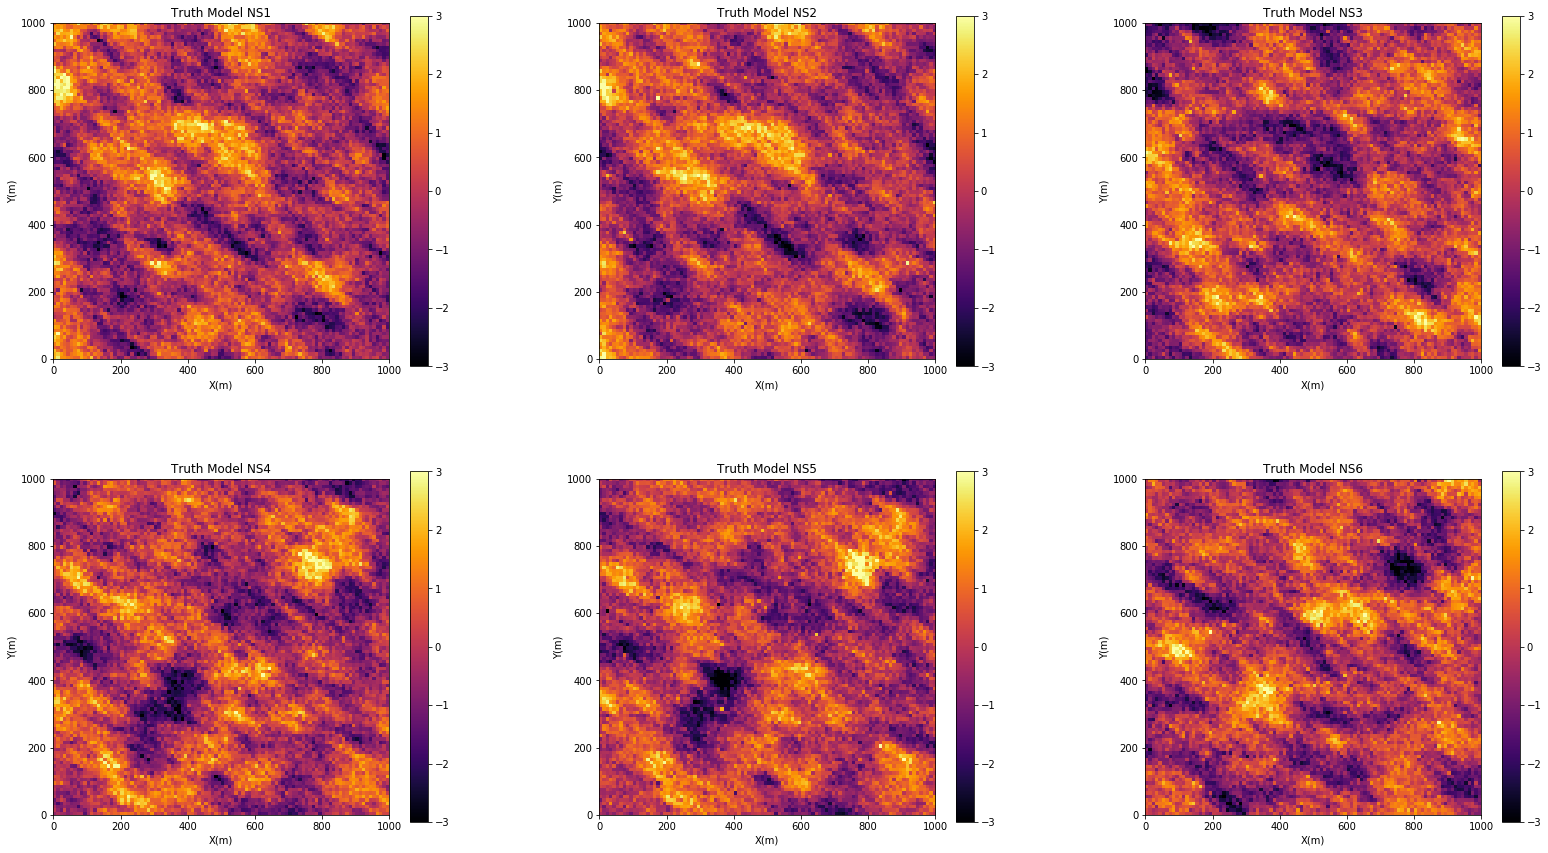

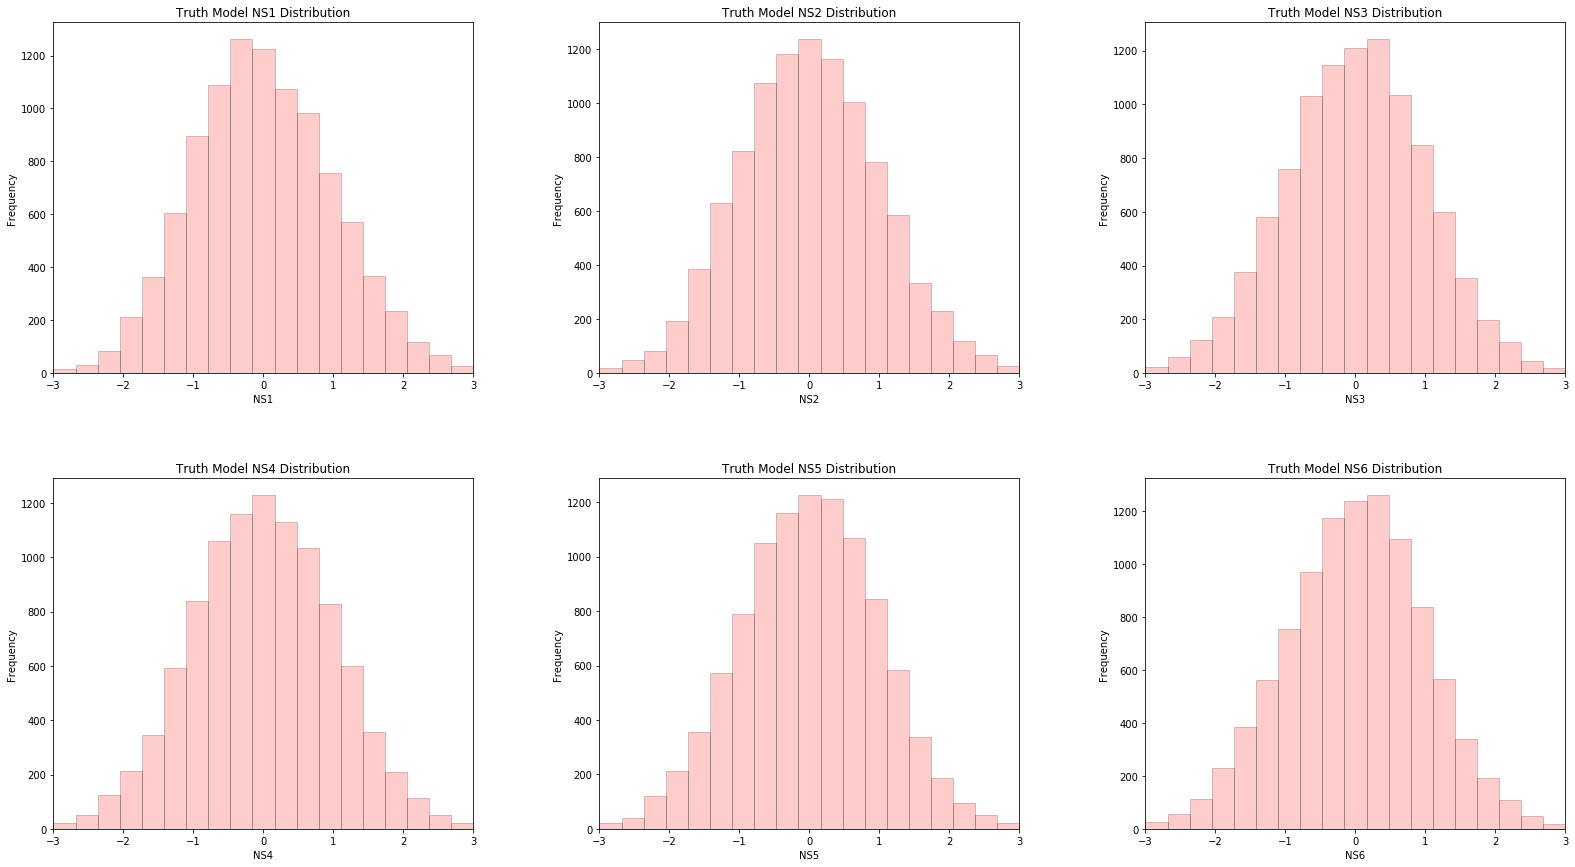

In [10]:
# Visualize the Truth Model Map and Histogram
for i in range(0,6):
    plt.subplot(2,3,i+1)
    plt.xlabel('X(m)'); plt.ylabel('Y(m)')
    plt.title('Truth Model NS' + str(i+1))  
    plt.imshow(sim_ns[i,:,:],interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = -3, vmax = 3,cmap = cmap)
    cbar = plt.colorbar()

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=2.8, wspace=0.3, hspace=0.3)
plt.show()    
    
for i in range(0,6):
    plt.subplot(2,3,i+1)
    plt.hist(sim_ns[i,:,:].flatten(),bins = np.linspace(vmin,vmax,20),alpha=0.2,color="red",edgecolor="black")
    plt.xlim([-3,3])
    plt.title('Truth Model NS' + str(i+1) + ' Distribution')
    plt.xlabel('NS'+str(i+1)); plt.ylabel('Frequency')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=2.8, wspace=0.3, hspace=0.3)
plt.show()

Let's also visualize the multivariate relationships

* we need to move from 2D ndarrays to DataFrames

C:\Users\17137\AppData\Roaming\Python\Python37\site-packages\seaborn\axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


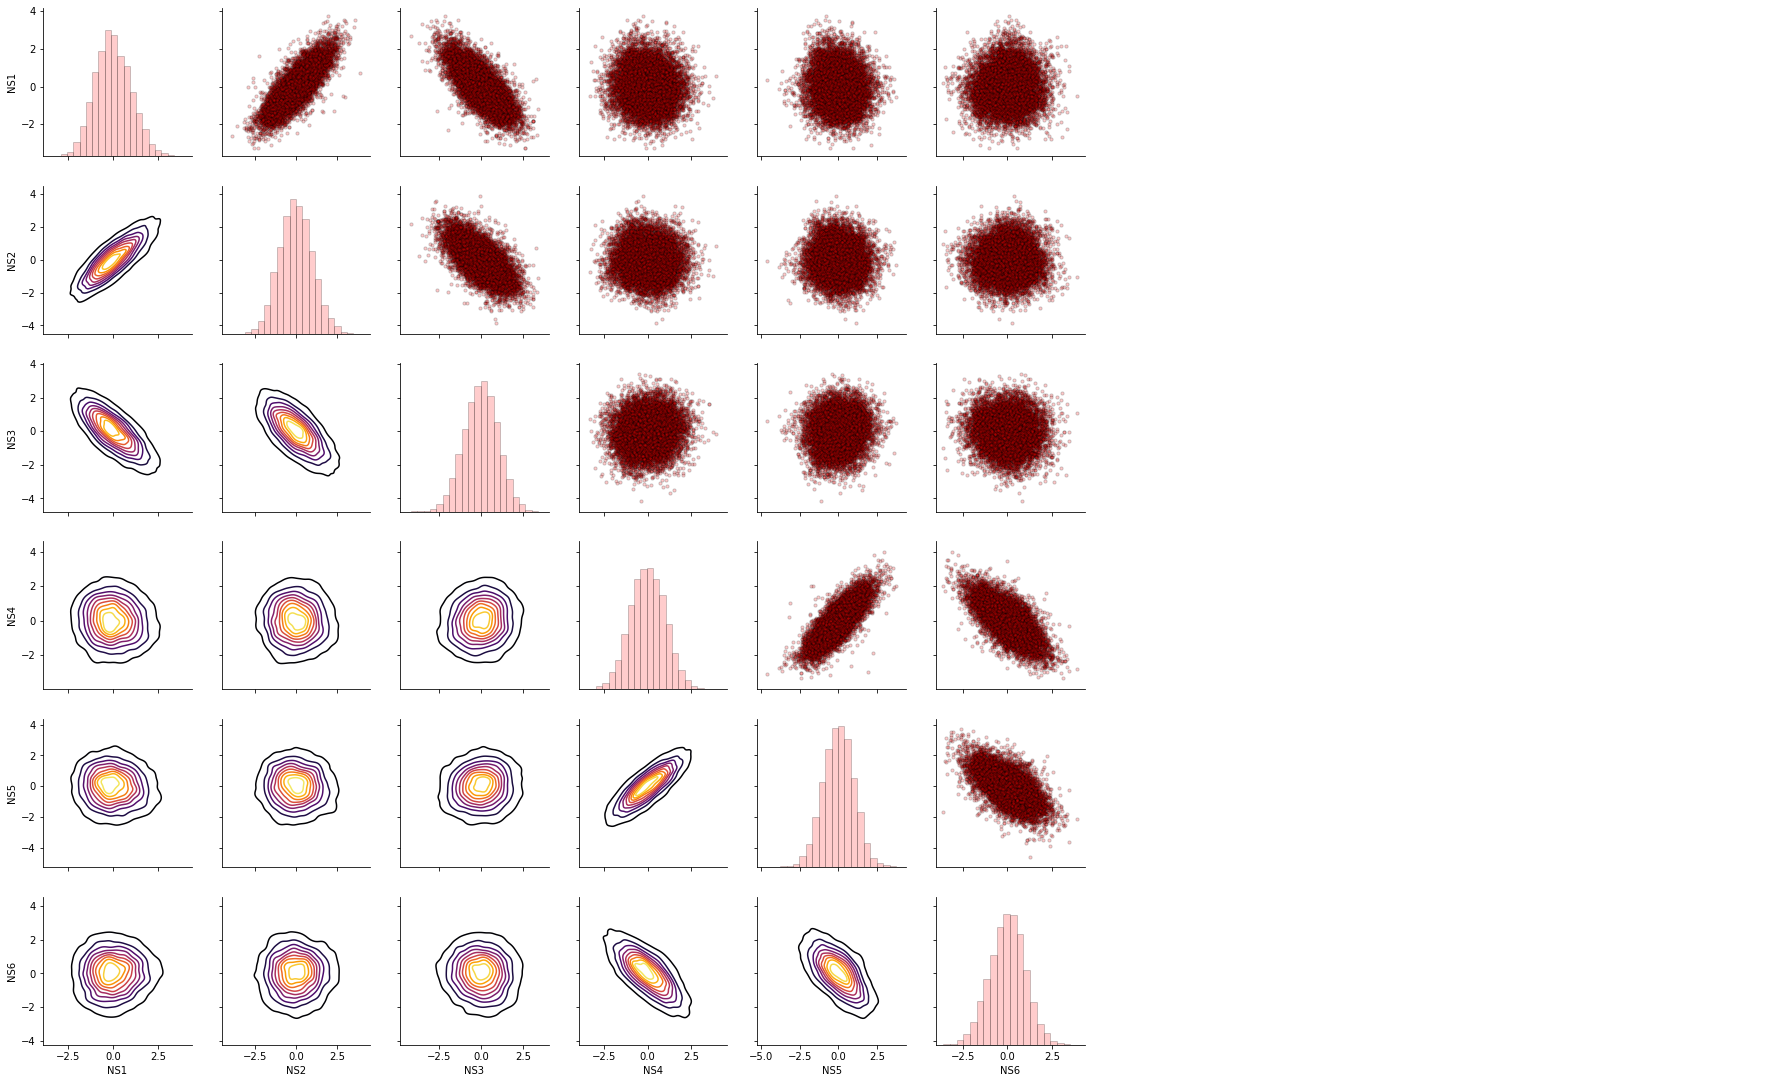

In [12]:
df_ns = pd.DataFrame({'NS1':sim_ns[0,:,:].flatten(),'NS2':sim_ns[1,:,:].flatten(),
                   'NS3':sim_ns[2,:,:].flatten(),'NS4':sim_ns[3,:,:].flatten(),
                   'NS5':sim_ns[4,:,:].flatten(),'NS6':sim_ns[5,:,:].flatten()})

pairgrid = sns.PairGrid(df_ns, size = 4)
pairgrid = pairgrid.map_upper(plt.scatter, color = 'red', edgecolor = 'black', alpha = 0.2, s = 10)
pairgrid = pairgrid.map_diag(plt.hist, bins = 20, color = 'red',alpha = 0.2, edgecolor = 'k')# Map a density plot to the lower triangle
pairgrid = pairgrid.map_lower(sns.kdeplot, cmap = plt.cm.inferno, 
                              shade = False, alpha = 1.0, n_levels = 10)
pairgrid.add_legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.6, top=0.6, wspace=0.2, hspace=0.2)

#### Transform the Gaussian Spatial Model to Features of Interest

We will transform the Gaussian features and add nonlinear structures.

Let's transform the Gaussian realizations to the desired sand facies continuous property distributions.

C:\Users\17137\AppData\Roaming\Python\Python37\site-packages\seaborn\axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


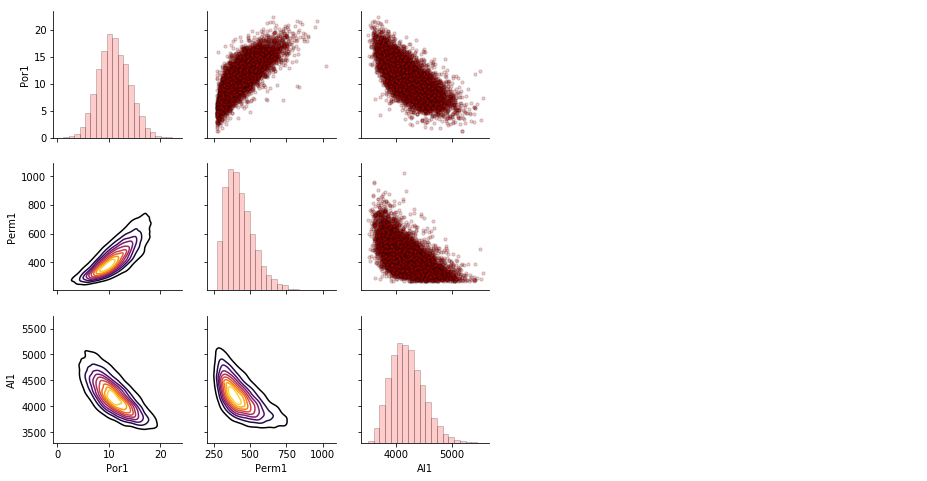

In [14]:
df_ns['Por1'] = GSLIB.affine(df_ns['NS1'],11.0,3.0)

a = 2.5; b = 15; c = 10
# impose nonlinearity through a quadratic transform of the permeability 
df_ns['Perm1'] = a * df_ns['NS2'] * df_ns['NS2'] + b * df_ns['NS2'] + c 
df_ns['Perm1'] = GSLIB.affine(df_ns['Perm1'],4.3,1.0)*100

a = 5.5; b = 50; c = 100
df_ns['AI1'] = a * df_ns['NS3'] * df_ns['NS3'] + b * df_ns['NS3'] + c 
df_ns['AI1'] = GSLIB.affine(df_ns['AI1'],4.2,0.3)*1000

df_ns['facies1'] = np.full(len(df_ns),1)

pairgrid = sns.PairGrid(df_ns, vars = ['Por1','Perm1','AI1'],size = 4)
pairgrid = pairgrid.map_upper(plt.scatter, color = 'red', edgecolor = 'black', alpha = 0.2, s = 10)
pairgrid = pairgrid.map_diag(plt.hist, bins = 20, color = 'red',alpha = 0.2, edgecolor = 'k')# Map a density plot to the lower triangle
pairgrid = pairgrid.map_lower(sns.kdeplot, cmap = plt.cm.inferno, 
                              shade = False, alpha = 1.0, n_levels = 10)
pairgrid.add_legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.5, wspace=0.2, hspace=0.2)


Now, let's transform the Gaussian realizations to the desired shale facies continuous property distributions.

C:\Users\17137\AppData\Roaming\Python\Python37\site-packages\seaborn\axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
C:\Users\17137\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\17137\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\17137\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


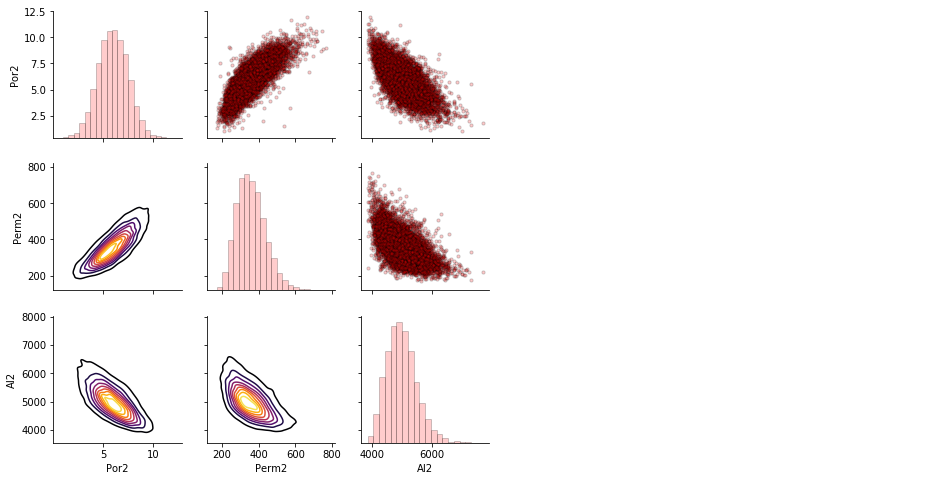

In [15]:
df_ns['Por2'] = GSLIB.affine(df_ns['NS4'],6.0,1.5)

#a = 5.5; b = 35; c = 100
# impose nonlinearity through a quadratic transform of the permeability 
df_ns['Perm2'] = a * df_ns['NS5'] * df_ns['NS5'] + b * df_ns['NS5'] + c 
df_ns['Perm2'] = GSLIB.affine(df_ns['Perm2'],1.8,0.4)*200

a = 5.5; b = 50; c = 100
df_ns['AI2'] = a * df_ns['NS6'] * df_ns['NS6'] + b * df_ns['NS6'] + c 
df_ns['AI2'] = GSLIB.affine(df_ns['AI2'],5.0,0.5)*1000

df_ns['facies2'] = np.full(len(df_ns),0)

pairgrid = sns.PairGrid(df_ns, vars = ['Por2','Perm2','AI2'],size = 4)
pairgrid = pairgrid.map_upper(plt.scatter, color = 'red', edgecolor = 'black', alpha = 0.2, s = 10)
pairgrid = pairgrid.map_diag(plt.hist, bins = 20, color = 'red',alpha = 0.2, edgecolor = 'k')# Map a density plot to the lower triangle
pairgrid = pairgrid.map_lower(sns.kdeplot, cmap = plt.cm.inferno, 
                              shade = False, alpha = 1.0, n_levels = 10)
pairgrid.add_legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.5, wspace=0.2, hspace=0.2)


We can now return to 2D ndarrays for the continuous properties for sand and shale

* we visualize the exhaustive models to check the results

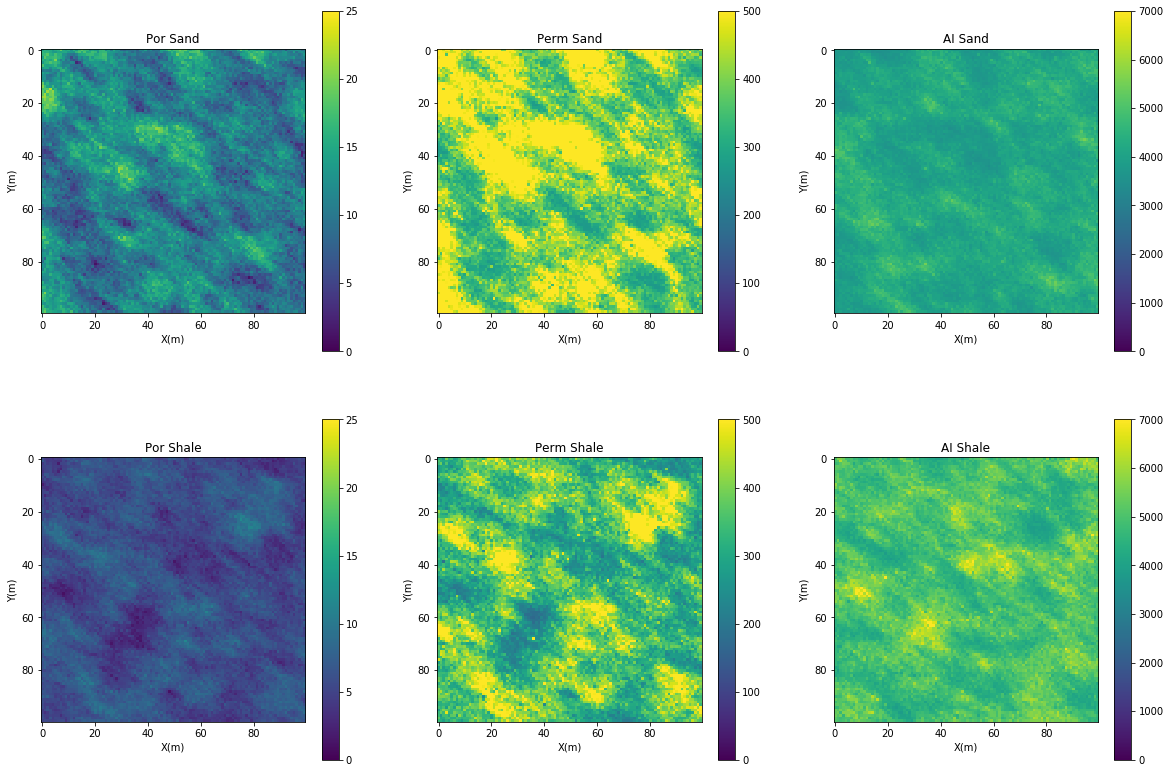

In [16]:
por1 = df_ns['Por1'].values.reshape([ny,nx])
perm1 = df_ns['Perm1'].values.reshape([ny,nx])
AI1 = df_ns['AI1'].values.reshape([ny,nx])

por2 = df_ns['Por2'].values.reshape([ny,nx])
perm2 = df_ns['Perm2'].values.reshape([ny,nx])
AI2 = df_ns['AI2'].values.reshape([ny,nx])

plt.subplot(231)
plt.imshow(por1,vmin = 0.0,vmax = 25); plt.colorbar(); plt.xlabel('X(m)'); plt.ylabel('Y(m)'); plt.title('Por Sand')

plt.subplot(232)
plt.imshow(perm1,vmin = 0.0,vmax = 500); plt.colorbar(); plt.xlabel('X(m)'); plt.ylabel('Y(m)'); plt.title('Perm Sand')

plt.subplot(233)
plt.imshow(AI1,vmin = 0.0,vmax = 7000); plt.colorbar(); plt.xlabel('X(m)'); plt.ylabel('Y(m)'); plt.title('AI Sand')

plt.subplot(234)
plt.imshow(por2,vmin = 0.0,vmax = 25); plt.colorbar(); plt.xlabel('X(m)'); plt.ylabel('Y(m)'); plt.title('Por Shale')

plt.subplot(235)
plt.imshow(perm2,vmin = 0.0,vmax = 500); plt.colorbar(); plt.xlabel('X(m)'); plt.ylabel('Y(m)'); plt.title('Perm Shale')

plt.subplot(236)
plt.imshow(AI2,vmin = 0.0,vmax = 7000); plt.colorbar(); plt.xlabel('X(m)'); plt.ylabel('Y(m)'); plt.title('AI Shale')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.6, top=2.6, wspace=0.2, hspace=0.2)

#### Make a facies model 

Use sequential indicator simulation to make a facies model.

Data for IK3D: Variable column Facies
  Number   = 100
Setting up rotation matrices for variogram and search
Working on a single realization, seed 73074
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000


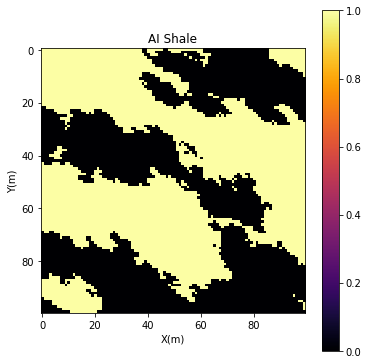

In [17]:
# Make a facies model 

# Sequential Indicator Simulation with Simple Kriging Multiple Realizations 
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; nodmax = 10; radius = 400; skmean = 0
tmin = -999; tmax = 999
df_dummy_facies = pd.DataFrame({'X':np.full(100,-9999),'Y':np.full(100,-9999),'Facies':np.full(100,0)})
dummy_trend = np.zeros((10,10,2))            # the current version requires trend input - if wrong size it is ignored 

ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories (use consisten order)
gcdf = [0.4,0.6]                           # the global proportions of the categories
varios = []                                # the variogram list
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=-60,hmaj1=500,hmin1=250)) # shale indicator variogram
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=-60,hmaj1=500,hmin1=250)) # sand indicator variogram

sisim = geostats.sisim(df_dummy_facies,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf,trend=dummy_trend,
               tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
               nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = 73074,
               ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,radius=radius,ktype=0,vario=varios)

plt.subplot(236)
plt.imshow(sisim,vmin = 0.0,vmax = 1.0,cmap = plt.cm.inferno); plt.colorbar(); plt.xlabel('X(m)'); plt.ylabel('Y(m)'); plt.title('AI Shale')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.6, top=2.6, wspace=0.2, hspace=0.2)


#### Merge Continuous Properties by Facies

We merge the facies models by retaining the continuous feature for sand value in the sand locations and continuous feature for shale values in the shale locations.

* this is the geomodeling 'cookie-cutter approach

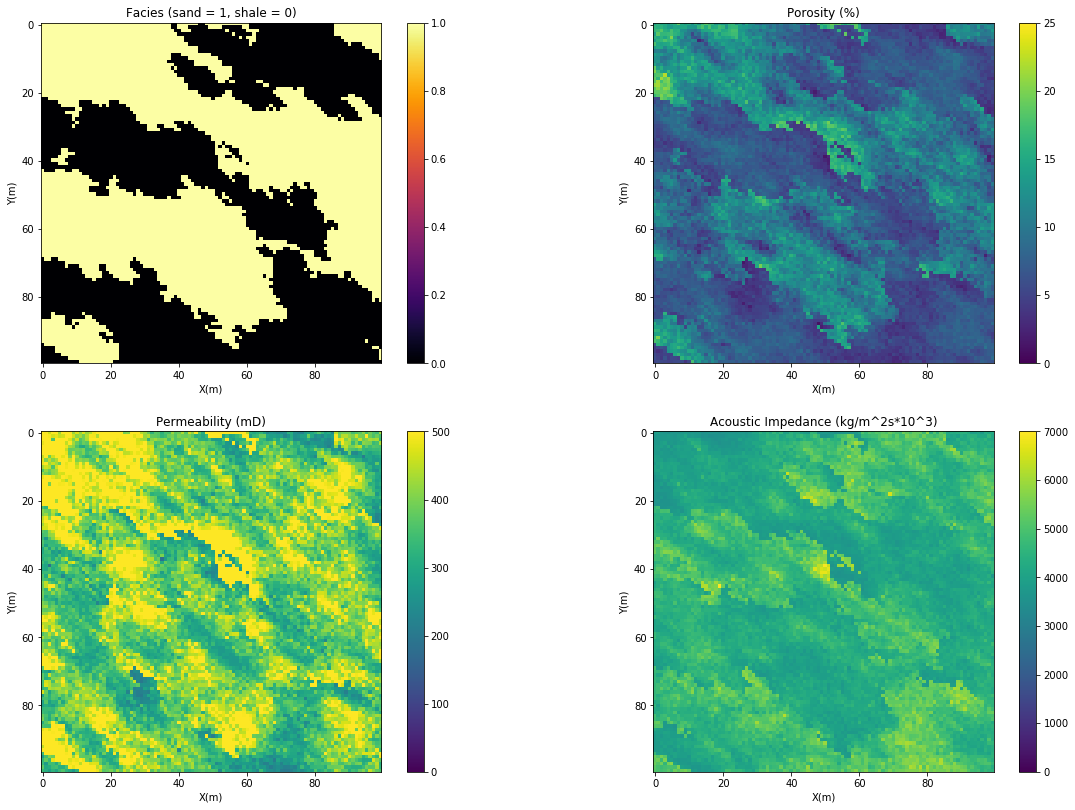

In [18]:
facies = np.zeros([ny,nx])
por = np.zeros([ny,nx])
perm = np.zeros([ny,nx])
AI = np.zeros([ny,nx])

for iy in range(0,ny):
    for ix in range(0,nx):
        if sisim[iy,ix] > 0.5:   # current location is assumed to be sand
            facies[iy,ix] = 1
            por[iy,ix] = por1[iy,ix];
            perm[iy,ix] = perm1[iy,ix];
            AI[iy,ix] = AI1[iy,ix]
        else:                      # current location is assumed to be shale
            facies[iy,ix] = 0
            por[iy,ix] = por2[iy,ix];
            perm[iy,ix] = perm2[iy,ix];
            AI[iy,ix] = AI2[iy,ix]
            
plt.subplot(221)
plt.imshow(facies,vmin = 0.0,vmax = 1.0,cmap = plt.cm.inferno); plt.colorbar(); plt.xlabel('X(m)'); plt.ylabel('Y(m)'); plt.title('Facies (sand = 1, shale = 0)')
            
plt.subplot(222)
plt.imshow(por,vmin = 0.0,vmax = 25); plt.colorbar(); plt.xlabel('X(m)'); plt.ylabel('Y(m)'); plt.title('Porosity (%)')

plt.subplot(223)
plt.imshow(perm,vmin = 0.0,vmax = 500); plt.colorbar(); plt.xlabel('X(m)'); plt.ylabel('Y(m)'); plt.title('Permeability (mD)')

plt.subplot(224)
plt.imshow(AI,vmin = 0.0,vmax = 7000); plt.colorbar(); plt.xlabel('X(m)'); plt.ylabel('Y(m)'); plt.title('Acoustic Impedance (kg/m^2s*10^3)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.6, top=2.6, wspace=0.2, hspace=0.2)


#### Sample from the Truth Model for Each Feature

The following sampling workflow includes the following steps:

1. Apply Regular Sampling
2. Apply Random Sampling
3. Combine the Regular and Random Samples
4. Apply Rejection Sampling to Impose Bias
5. Remove Spatial Duplicates 

We check for and remove spatial duplicates, while each step will not produce duplicates (samples coincidental in space), this is a low probability of this occuring between steps.

* spatial duplicates cause analysis issues such as singular matrices for kriging etc.

You can adjust the following parameters to customize your sample set:

* **spacing** - the interwell spacing in x and y of the regular samples
* **nrandom_sample** - the number of random samples
* **wt_min** - the relative weight of the lowest value - linear interpolation is applied between min and max values
* **wt_max** - the relative weight of the highest value
* **bias_frac** -the proportion of the dataset to reject

Some other ideas:

* limit the regular and random samples to subsets of the truth model (use minsx,maxsx,minsy,maxsy)
* use multiple regular sample sets over different parts of the truth model
* use multiple random sample sets over different parts of the truth model with different sampling densities
* change the random number seed to get multiple datasets with the same sampling parameters

With the provided operations there is a lot of flexibility to build a unique sample set. The following workflow is a simple demonstration:

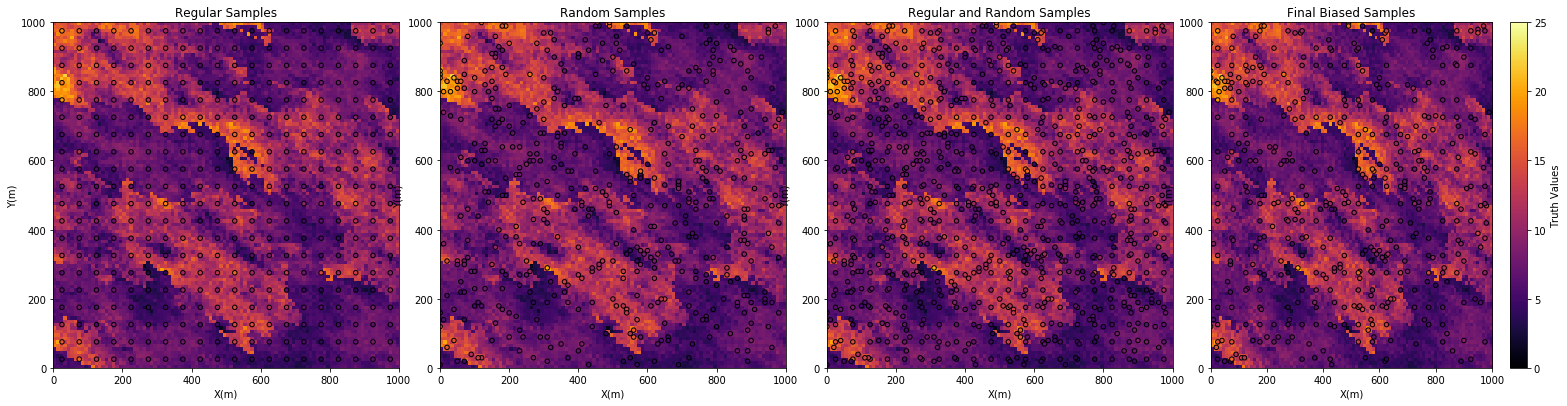

Number of data - 450


In [20]:
# Data Set Sampling Paramters
spacing = 50                              # spacing of regular samples
nrandom_sample = 500                      # number of random samples
wt_min = 0.1; wt_max = 1.0                # weigths of minimum and maximum feature values - control on degree of bias 
bias_frac = 0.5                           # fration of dataset to remove with rejection sampler
seed = 73073                              # random number seed
vmin = 0.0; vmax = 25.0

np.random.seed(seed = seed)               # set the random number seed for repeatability of samples

# Regular Sampling
regular_samples = regular_sample_MV(por,perm,AI,facies,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,spacing=spacing,
                         minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name="Por",name2="Perm",name3="AI",name4="Facies")

# Random Sampling
random_samples = random_sample_MV(por,perm,AI,facies,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,
                               nsamp = nrandom_sample,minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,
                               name="Por",name2="Perm",name3="AI",name4="Facies")

# Concatenate (Combine) Regular and Random Samples into One DataFrame  
samples = pd.concat([regular_samples,random_samples])

# Rejection Sampler
biased_samples = rejection_sample(samples,"Por",1-bias_frac,wt_min,wt_max)

# Remove Dupicates 
biased_samples = biased_samples[np.invert(biased_samples.duplicated(subset=['X','Y'],keep='first'))] 

# Drop the weights column
biased_samples = biased_samples.drop('weights',axis=1)  

# Visualize Each Step of the Process and the Final Sample Set and Truth Model
plt.subplot(141)
plt.xlabel('X(m)'); plt.ylabel('Y(m)')
plt.title('Regular Samples')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(por,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = palette)
plt.scatter(regular_samples['X'],regular_samples['Y'],c = regular_samples["Por"],s = 20, cmap = palette,vmin = vmin, vmax = vmax, 
                        edgecolors = 'black',label = 'Regular Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])

plt.subplot(142)
plt.xlabel('X(m)'); plt.ylabel('Y(m)')
plt.title('Random Samples')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(por,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = palette)
plt.scatter(random_samples['X'],random_samples['Y'],c = random_samples["Por"],s = 20, cmap = palette,vmin = vmin, vmax = vmax, 
                        edgecolors = 'black',label = 'Random Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])

plt.subplot(143)
plt.xlabel('X(m)'); plt.ylabel('Y(m)')
plt.title('Regular and Random Samples')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(por,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = palette)
plt.scatter(samples['X'],samples['Y'],c = samples["Por"],s = 20, cmap = palette,vmin = vmin, vmax = vmax, 
                        edgecolors = 'black',label = 'Regular and Random Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])

plt.subplot(144)
plt.xlabel('X(m)'); plt.ylabel('Y(m)')
plt.title('Final Biased Samples')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(por,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = palette)
plt.scatter(biased_samples['X'],biased_samples['Y'],c = biased_samples["Por"],s = 20, cmap = palette,vmin = vmin, vmax = vmax, 
                        edgecolors = 'black',label = 'Biased Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
ax4 = plt.gca()
cbar = plt.colorbar()
cbar.set_label('Truth Values')
ax4.set_aspect('auto')
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=1.2, wspace=0.1, hspace=0.2)
plt.show()  

print('Number of data - ' + str(len(biased_samples)))

In [21]:
std_error = 300 # add random error
biased_samples['Perm'] = biased_samples['Perm'] + np.random.normal(loc = 0.0,scale=std_error,size=len(biased_samples))

num = biased_samples._get_numeric_data()                         # get the numerical values
num[num < 0] = 0                                                 # truncate negative values to 0.0
biased_samples.describe().transpose()                            # calculate summary statistics for the data


,count,mean,std,min,25%,50%,75%,max
X,450.0,473.411111,286.155840,0.000000,225.000000,477.500000,720.000000,990.000000
Y,450.0,505.586667,283.425990,9.000000,275.000000,489.000000,736.500000,999.000000
Por,450.0,9.772141,3.562372,2.993237,6.945830,9.202728,12.270544,20.835838
Perm,450.0,424.275529,288.686956,0.000000,211.420174,411.613538,601.804111,1518.001627
AI,450.0,4410.660832,485.011917,3565.811095,4060.944042,4312.072539,4683.963086,5921.509968
Facies,450.0,0.651111,0.477149,0.000000,0.000000,1.000000,1.000000,1.000000


we visualize the results for porosity only above so we can check each of the sampling steps.

Now let's visualize the final product for all features.

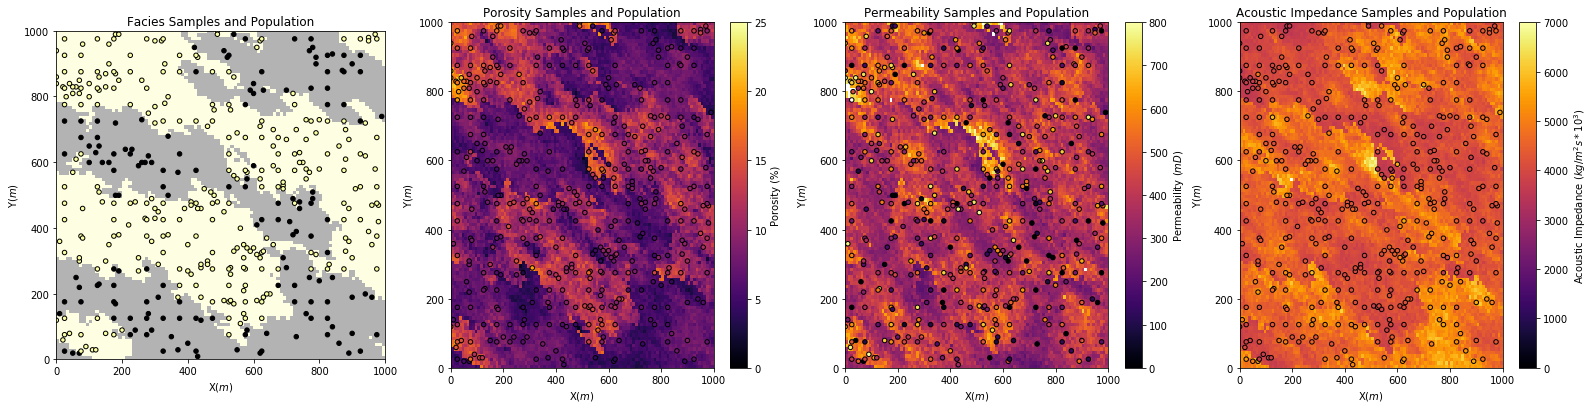

In [28]:
plt.subplot(142)
plt.xlabel('X($m$)'); plt.ylabel('Y($m$)')
plt.title('Porosity Samples and Population')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(por,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = palette)
plt.scatter(biased_samples['X'],biased_samples['Y'],c = biased_samples["Por"],s = 20, cmap = palette,vmin = vmin, vmax = vmax, 
                        edgecolors = 'black',label = 'Biased Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
ax4 = plt.gca()
cbar = plt.colorbar()
cbar.set_label('Porosity (%)')
ax4.set_aspect('auto')

plt.subplot(143)
plt.xlabel('X($m$)'); plt.ylabel('Y($m$)')
plt.title('Permeability Samples and Population')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(perm,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = 0, vmax = 800,cmap = palette)
plt.scatter(biased_samples['X'],biased_samples['Y'],c = biased_samples["Perm"],s = 20, cmap = palette,vmin = 0, vmax = 800, 
                        edgecolors = 'black',label = 'Biased Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
ax4 = plt.gca()
cbar = plt.colorbar()
cbar.set_label('Permeability ($mD$)')
ax4.set_aspect('auto')

plt.subplot(144)
plt.xlabel('X($m$)'); plt.ylabel('Y($m$)')
plt.title('Acoustic Impedance Samples and Population')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(AI,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = 0, vmax = 7000,cmap = palette)
plt.scatter(biased_samples['X'],biased_samples['Y'],c = biased_samples["AI"],s = 20, cmap = palette,vmin = 0, vmax = 7000, 
                        edgecolors = 'black',label = 'Biased Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
ax4 = plt.gca()
cbar = plt.colorbar()
cbar.set_label('Acoustic Impedance ($kg/m^2s*10^3$)')
ax4.set_aspect('auto')

plt.subplot(141)
plt.xlabel('X($m$)'); plt.ylabel('Y($m$)')
plt.title('Facies Samples and Population')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(facies,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = 0, vmax = 1,cmap = palette,alpha = 0.3)
plt.scatter(biased_samples['X'],biased_samples['Y'],c = biased_samples["Facies"],s = 20, cmap = palette,vmin = 0, vmax = 1, 
                        edgecolors = 'black',label = 'Biased Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
ax4 = plt.gca()
#cbar = plt.colorbar()
#cbar.set_label('Facies (sand = 1, shale = 0)')
#ax4.set_aspect('auto')
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=1.2, wspace=0.2, hspace=0.2)
plt.show()    

That looks really awesome! I like it. If you want to change it, there are plenty of options to change the truth models and the sampling design.

Let's also check the by-facies MV relationships with a matrix scatter plot.

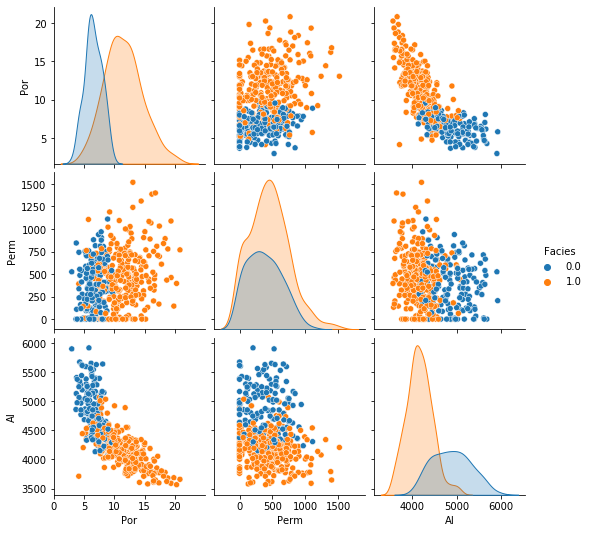

In [29]:
sns.pairplot(biased_samples, hue='Facies',vars=['Por','Perm','AI'],markers='o')

One more matrix scatter plot for good measuare. I should have colored by facies below.

C:\Users\17137\AppData\Roaming\Python\Python37\site-packages\seaborn\axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
C:\Users\17137\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\17137\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\17137\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


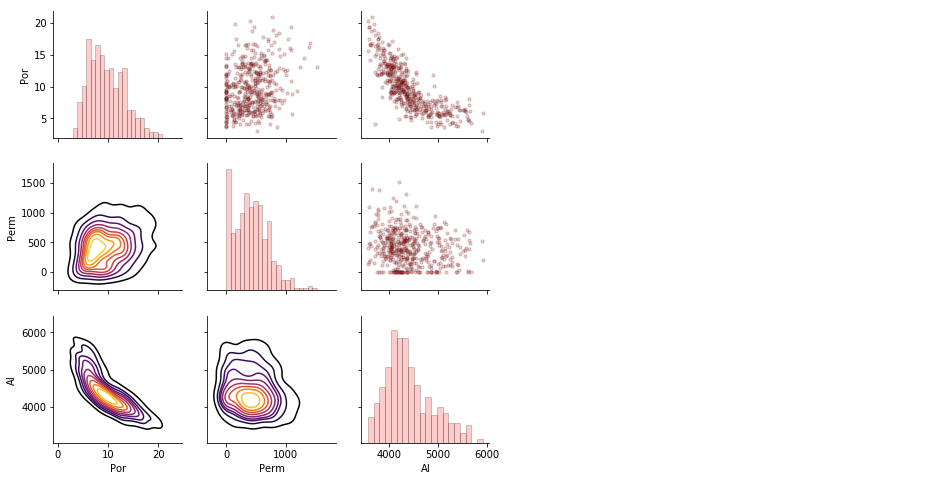

In [30]:
pairgrid = sns.PairGrid(biased_samples, vars = ['Por','Perm','AI'],size = 4)
pairgrid = pairgrid.map_upper(plt.scatter, color = 'red', edgecolor = 'black', alpha = 0.2, s = 10)
pairgrid = pairgrid.map_diag(plt.hist, bins = 20, color = 'red',alpha = 0.2, edgecolor = 'k')# Map a density plot to the lower triangle
pairgrid = pairgrid.map_lower(sns.kdeplot, cmap = plt.cm.inferno, 
                              shade = False, shade_lowest = False, alpha = 1.0, n_levels = 10)
pairgrid.add_legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.5, wspace=0.2, hspace=0.2)

#### Save the Truth Model and Sample Data

Now we finish up by saving the truth model and sample data. 

* sample data DataFrame (biased_sample) will be saved to a '.csv'

* truth model (sim) will be saved to a 

More information and examples for loading and saving data with [DataFrames](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/PythonDataBasics_DataFrame.ipynb) and [ndarrays](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/PythonDataBasics_ndarrays.ipynb).

We will complete the following steps:

1. set the working directory, target for the saved files

2. save the sample set 

3. save the truth model

In [31]:
import os
os.chdir('c:/PGE383')
biased_samples.to_csv('spatial_nonlinear_MV_facies_v5.csv')

#### Comments

It is helpful to be able to general reasonable/realistic dataset. I hope that this is helpful.

I'm always happy to discuss,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin